# Plot figures for paper

In [ ]:
import os
from pathlib import Path
import functools

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm, Normalize
import seaborn as sns

import hiv_bnab
from hiv_bnab.simulation import Simulation
from hiv_bnab import utils
from scripts.analyze_sweep import epitope_colors, darken_color

slide_width = 11.5
half_slide_width = 5.67
aspect_ratio = 5/7
cm_in_inch = 2.54
pres_params = {'axes.edgecolor': 'black',
                  'axes.facecolor':'white',
                  'axes.grid': False,
                  'axes.linewidth': 1.0,
                  'backend': 'ps',
                  'savefig.format': 'pdf',
                  'pdf.fonttype' : 42,
                  'ps.fonttype' : 42,
                  'figure.titlesize' : 8,
                  'figure.labelsize' : 8,
                  'axes.titlesize': 8,
                  'axes.labelsize': 8,
                  'legend.fontsize': 7,
                  'xtick.labelsize': 7,
                  'ytick.labelsize': 7,
                  'text.usetex': False,
                  'figure.figsize': [half_slide_width, half_slide_width * aspect_ratio],
                  'font.family': 'sans-serif',
                   'font.sans-serif' : 'Arial',
                  'font.size' : 8,
                  #'mathtext.fontset': 'cm',
                  'xtick.bottom':True,
                  'xtick.top': False,
                  'xtick.direction': 'out',
                  'xtick.major.pad': 2,
                  'xtick.major.size': 3,
                  'xtick.minor.bottom': False,
                  'xtick.major.width': 0.5,
                  'xtick.minor.width' : 0.3,
                  'xtick.minor.size' : 2.5,

                  'ytick.left':True,
                  'ytick.right':False,
                  'ytick.direction':'out',
                  'ytick.major.pad': 2,
                  'ytick.major.size': 3,
                  'ytick.major.width': 0.5,
                   'ytick.minor.width' : 0.3,
                  'ytick.minor.size' : 2.5,
                  'ytick.minor.right':False,
                  'lines.linewidth':1.5}
plt.rcParams.update(pres_params)

In [2]:
%matplotlib inline

In [3]:
#replace with your local paths
DIR = Path('/home/gridsan/dkannan/git-remotes/hiv-bnab/seeding_10_death_0.4_egc_ntfh_2000')
PLOT_DIR = Path('/home/gridsan/dkannan/git-remotes/hiv-bnab/plots/for_paper')

In [5]:
def plot_fdc_ab_ka(df, C, C0, num_traj=10):
    df = df[df['C0']==C0]
    df = df[df['fdc_capacity']==C]
    #first figure out which parameters were swept, based on number of unique values in each column
    params = list(df.columns)
    params.remove('path')
    df_excl_path = df[params]
    unique_counts = np.array(df_excl_path.nunique())
    swept_params = np.array(params)[unique_counts > 1]
    concentrations = ["ab_conc", "ab_ka", "ic_fdc_eff_conc"]
    conc_titles = ['[Ab] (nM)', '$K_a$ (nM$^{-1}$)', 'Unmasked [Ag] on FDC']
    ylims = [[1e-2, 100], [1e-3, 1e2], [C/1e2, 1.5*C]]
    n_ep = int(df['n_conserved_epitopes'].iloc[0] + df['n_variable_epitopes'].iloc[0] * df['n_ag'].iloc[0])
    mean_fn = functools.partial(np.mean, axis=1)
    for path, mat in df.groupby('path'):
        path = path.replace("gc_dynamics", "hiv-bnab")
        plotname = ''
        for key in swept_params:
            plotname += f'_{key}_{mat[key].iloc[0]}'
        results = utils.read_pickle(Path(path)/'conc_cells.pkl')
        nreplicates = results["plasma_gc"].shape[1]
        time = results["time"]
        
        """ PLOT [Ab], Ka OVER TIME """
        fig = plt.figure(figsize=(12.5 / cm_in_inch, 4.4 / cm_in_inch), layout="constrained")
        plot_idx = 1
        colors = sns.color_palette("Set2", n_ep)
        for j, conc in enumerate(concentrations):
            plt.subplot(1, 3, plot_idx)
            for i in range(n_ep):
                lower_bound = np.percentile(results[conc][0:250, :, i], 25, axis=1)
                upper_bound = np.percentile(results[conc][0:250, :, i], 75, axis=1)
                #plt.fill_between(time[0:250], lower_bound, upper_bound, color=colors[i], alpha=0.3, label='_nolegend_')
                #plot num_traj random individual trajectories to illustrate stochastic variation
                trajs = results[conc].shape[1]
                traj_inds = np.random.randint(0, trajs, size=num_traj)
                plt.plot(time[0:250], results[conc][0:250, traj_inds, i], lw=.3, color=colors[i], label='_nolegend_')
                plt.plot(time[0:250], mean_fn(results[conc][0:250, :, i]), color=darken_color(colors[i], 0.1), lw=2)
            plt.yscale('log')
            #plt.yticks([10, 1e-2, 1e-5])
            plt.xlabel('time (days)')
            plt.title(conc_titles[j])
            plt.ylim(ylims[j])
            if conc == "ic_fdc_eff_conc":
                plt.legend([f'ep {i+1}' for i in range(n_ep)], loc="upper right", fontsize=7)
            else:
                plt.legend([f'ep {i+1}' for i in range(n_ep)], loc="lower right", fontsize=7)
            plot_idx += 1
        #fig.suptitle(plottitle)
        #fig.supxlabel('time (days)')
        fig.tight_layout()
        plt.savefig(PLOT_DIR/f"3_epitope_sweep_C{C}_C0{C0}_concs{plotname}.pdf")

In [5]:
df = pd.read_csv(DIR/'masking_sweep_C0_1.0/sweep_map.csv')
df = df[df['seeding_tcells_egc']==200]
df = df[df['masking']==1]
#df[np.isclose(df['epitope_overlap'],0.6)]
df

,simulation_time,n_conserved_epitopes,n_variable_epitopes,n_ag,fdc_capacity,C0,bcell_birth_rate,bcell_death_rate,seeding_tcells_gc,n_tfh_gc,...,memory_to_gc_fraction,n_naive_precursors,masking,write_simulation,seed,path,ep1_titer_d400,ep2_titer_d400,ep3_titer_d400,gc_size_d400
0,400,3,0,2,1.0,1.0,2.77,0.4,10,200,...,0,2000,1,False,0,/home/gridsan/dkannan/git-remotes/gc_dynamics/...,149.369264,125.294331,117.304936,524.8286


/tmp/ipykernel_1078840/39028899.py:51: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


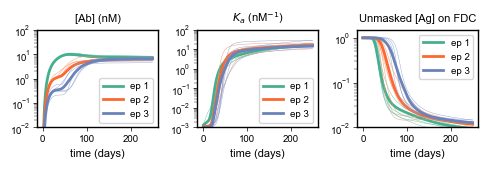

In [6]:
plot_fdc_ab_ka(df, 1.0, 1.0, num_traj=5)

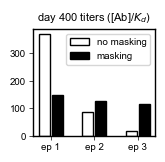

In [8]:
df = pd.read_csv(DIR/'masking_sweep_C0_1.0/sweep_map.csv')
fig, ax = plt.subplots(figsize=(4.3 / cm_in_inch, 4.224 / cm_in_inch))
n_ep = int(df['n_conserved_epitopes'].iloc[0] + df['n_variable_epitopes'].iloc[0] * df['n_ag'].iloc[0])
x = np.arange(n_ep)
width = 0.25
space = 0.05
colors = epitope_colors(n_ep)
path = df['path'].iloc[0]
path = path.replace("gc_dynamics", "hiv-bnab")
results = utils.read_pickle(Path(path)/'conc_cells.pkl')
nreplicates = results["plasma_gc"].shape[1]
mask_labels = {0 : 'no masking', 1: 'masking'}
bar_properties = {
    0: {'color': 'white', 'edgecolor': 'black'},  # no masking
    1: {'color': 'black', 'edgecolor': 'black'}   # with masking
}

multiplier = 0
for mask, mat in df.groupby('masking'):
    offset = (width + space) * multiplier
    titers = [mat[f'ep{i+1}_titer_d400'].values[0] for i in range(n_ep)]
    props = bar_properties[mask]
    rects = ax.bar(x+offset, titers, width, color=props['color'], edgecolor=props['edgecolor'], label=mask_labels[mask])
    #ax.bar_label(rects, padding=3)
    multiplier += 1

centered_x = x + (width + space) / 2
ax.set_xticks(centered_x, [f'ep {i+1}' for i in range(n_ep)])
ax.set_title('day 400 titers ([Ab]/$K_d$)')
#ax.set_yscale('log')
ax.legend(ncols=1, fontsize=7)
fig.tight_layout()
plt.savefig(PLOT_DIR/'end_titers_masking_C1.0_C01.0.pdf')

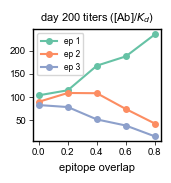

In [10]:
def plot_epitope_overlap(df):
    fig, ax = plt.subplots(figsize=(4.45 / cm_in_inch, 4.75 / cm_in_inch))
    df = df.sort_values('epitope_overlap')
    n_ep = int(df['n_conserved_epitopes'].iloc[0] + df['n_variable_epitopes'].iloc[0] * df['n_ag'].iloc[0])
    epitope_overlaps = df['epitope_overlap']
    day200_titers = np.zeros((len(epitope_overlaps), n_ep))
    j = 0
    for path, mat in df.groupby('path'):
        path = path.replace("gc_dynamics", "hiv-bnab")
        results = utils.read_pickle(Path(path)/'conc_cells.pkl')
        titer = results["ab_conc"] * results["ab_ka"]
        for i in range(n_ep):
            day200_titers[j, i] = np.mean(titer[200, :, i], axis=0)
        j += 1
    
    colors = sns.color_palette("Set2", n_ep)
    path = df['path'].iloc[0]
    path = path.replace("gc_dynamics", "hiv-bnab")
    results = utils.read_pickle(Path(path)/'conc_cells.pkl')
    nreplicates = results["plasma_gc"].shape[1]
    time = results["time"]
    for i in range(n_ep):
        #ax.plot(df['epitope_overlap'], df[f'ep{i+1}_titer_d400'], '-o', color=colors[i], label=f'ep {i+1}')
        ax.plot(df['epitope_overlap'][:-1], day200_titers[:-1, i], '-o', 
                color=colors[i], markersize=4, label=f'ep {i+1}')
    ax.set_xlabel('epitope overlap')
    ax.set_xticks(df['epitope_overlap'][:-1])
    ax.set_title('day 200 titers ([Ab]/$K_d$)')
    #ax.set_yscale('log')
    ax.legend(fontsize=6)
    fig.tight_layout()
    plt.savefig(PLOT_DIR/'end_titers_epitope_overlap.pdf')

df_ep = pd.read_csv(DIR/'epitope_overlap_3cons_C0_1.0/sweep_map.csv')
df = df_ep[df_ep['seeding_tcells_egc']==200]
plot_epitope_overlap(df)

In [11]:
def plot_epitope_titers_bar_graph(df, C0=1.0):
    df = df[df['C0']==C0]
    df.sort_values('fdc_capacity', inplace=True)
    sim_labels = [f'{C}' for C in df['fdc_capacity']]
    n_epitopes = len([col for col in df.columns if 'ep' in col and 'titer_d400' in col])
    colors = epitope_colors(n_epitopes)

    fig, ax = plt.subplots(figsize=(11.4 / cm_in_inch, 4.0 / cm_in_inch))
    
    bar_width = 0.15
    indices = np.arange(len(df)) * (n_epitopes * bar_width + 0.1)
    
    for i, ep in enumerate(range(1, n_epitopes + 1)):
        bar_positions = indices + i * bar_width
        ax.bar(bar_positions, df[f'ep{ep}_titer_d400'], width=bar_width, label=f'ep {ep}', color=colors[i], edgecolor='black')
    
    ax.set_ylabel('Titers ($[Ab]/K_d$)')
    ax.set_xlabel('Antigen concentration on FDC (nM)')
    ax.legend()
    #ax.set_yscale('log')  
    #ax.axhline(y=10, color='black', linestyle='--') 
    ax.set_xticks(indices + (n_epitopes - 1) * bar_width / 2)
    ax.set_xticklabels(sim_labels)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    fig.tight_layout()
    plt.savefig(PLOT_DIR/f'titers_vs_C_3ep_C0={C0}.pdf')

/tmp/ipykernel_1078840/2058684727.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values('fdc_capacity', inplace=True)


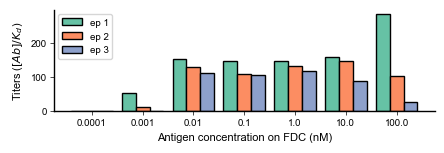

In [12]:
df = pd.read_csv(DIR/'3_epitope_sweep_C_C0/sweep_map.csv')
plot_epitope_titers_bar_graph(df, C0=1.0)

In [13]:
#make a summary figure where x axis is total number of epitopes, y axis is titers to all epitopes
#colored by whether they are unique to Ag1, unique to Ag2, or shared
from matplotlib.lines import Line2D

def plot_summary_figure_shared_epitopes(C=1.0, C0=1.0, f_ag2=0.5, ep_per_ag=6, n_ag=2, 
                                        titer_threshold=50, markersize=3):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11.4 / cm_in_inch, 4 / cm_in_inch),
                                   gridspec_kw={'width_ratios': [2.5, 1]})
    # Markers for Ag1, Ag2, conserved
    markers = ['d', 's', 'o']
    # Colors for Ag1, Ag2, conserved
    colors = sns.color_palette("Set2", 8)[5:]
    
    # Generate a random jitter for each epitope number to prevent vertical stacking
    jitter = np.random.uniform(-0.1, 0.1, size=(ep_per_ag * n_ag,))

    for n_ep in range(ep_per_ag, ep_per_ag * n_ag + 1):
        # Calculate the number of conserved epitopes
        n_conserved_ep = n_ag * ep_per_ag - n_ep
        n_variable_ep = ep_per_ag - n_conserved_ep
        # Calculate boundary between ep1, ep2, conserved
        conserved_idx_start = n_ep - n_conserved_ep
        ag2_idx_start = conserved_idx_start - n_variable_ep
        
        sweep_results = DIR/f'12_epitope_sweep/{n_ep}_epitope_sweep/sweep_map.csv'
        if sweep_results.is_file():
            df = pd.read_csv(DIR/f'12_epitope_sweep/{n_ep}_epitope_sweep/sweep_map.csv')
            df = df[df['C0'] == C0]
            df = df[df['f_ag2'] == f_ag2]
            category = 0
            num_potent_responses = 0
            for i, ep in enumerate(range(1, n_ep + 1)):
                if i >= ag2_idx_start and i < conserved_idx_start:
                    category = 1
                if i >= conserved_idx_start:
                    category = 2
                # Apply jitter to the x-values for better visibility
                ax1.plot(n_conserved_ep + np.random.uniform(-0.1, 0.1), df[f'ep{ep}_titer_d400'], 
                        marker=markers[category], color=colors[category], markersize=markersize,
                        markeredgewidth=0.3, markeredgecolor='black')
                if df[f'ep{ep}_titer_d400'].values[0] > titer_threshold:
                    num_potent_responses += 1
            ax2.plot(n_conserved_ep, num_potent_responses, 'o-', markeredgecolor='k', color='white',
                     markeredgewidth=0.5, markersize=4)
    
    # Custom legend for the plot
    legend_elements = [
        Line2D([0], [0], marker=markers[0], markerfacecolor=colors[0], color='w', 
               markeredgecolor='black', label='epitope on Ag1', markeredgewidth=0.3, markersize=markersize),
        Line2D([0], [0], marker=markers[1], markerfacecolor=colors[1], color='w', 
               markeredgecolor='black', label='epitope on Ag2', markeredgewidth=0.3, markersize=markersize),
        Line2D([0], [0], marker=markers[2], markerfacecolor=colors[2], color='w', 
               markeredgecolor='black', label='shared', markeredgewidth=0.3, markersize=markersize)
    ]
    #ax1.legend(handles=legend_elements)
    
    # Adjust x-axis label to show the number of conserved epitopes
    ax1.set_xlabel('Number of shared epitopes')
    ax1.set_ylabel('Titers ([Ab]/$K_d$)')
    ax1.set_xlim([-0.5, 6.5])  # X-axis limits to match the range of conserved epitopes (0-6)
    ax1.legend(handles=legend_elements, ncol=3, bbox_to_anchor=(0.5, 1.15), 
               loc='center', columnspacing=0.5, handletextpad=0.3, frameon=False)
    
    ax2.set_xlabel('# shared epitopes')
    ax2.set_xticks([0, 2, 4, 6])
    ax2.set_ylabel(f'#Abs with Titer > {titer_threshold}')
    
    fig.tight_layout()
    plt.savefig(PLOT_DIR/'titers_vs_shared_epitopes.pdf')

# Assuming 'DIR' is defined as the root directory for your data files


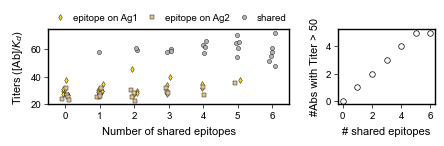

In [14]:
plot_summary_figure_shared_epitopes()

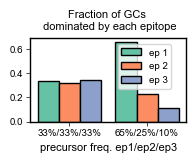

In [ ]:
#plot fraction of GCs that target each epitope for 2 sets of naive target fractions
balanced_ntf = [1./3., 1./3., 1./3.]
imbalanced_ntf = [0.65, 0.25, 0.1]
balanced_GCf = [0.3325, 0.3208, 0.3467] #data printed out by clonal_diversity.py script
imbalanced_GCf = [0.6603, 0.2272, 0.1125] #data printed out by clonal_diversity.py script
n_ep = 3
colors = epitope_colors(n_ep)

fig, ax = plt.subplots(figsize=(5.08 / cm_in_inch, 4.25 / cm_in_inch))
bar_width = 0.15
indices = np.arange(2) * (n_ep * bar_width + 0.1)

for i in range(n_ep):
    bar_positions = indices + i * bar_width
    ax.bar(bar_positions, [balanced_GCf[i], imbalanced_GCf[i]], width=bar_width, label=f'ep {i+1}', color=colors[i], edgecolor='black')

ax.set_xticks(indices + (n_ep - 1) * bar_width / 2)
ax.set_xticklabels(['33%/33%/33%', '65%/25%/10%'])
ax.set_title('Fraction of GCs \n dominated by each epitope')
ax.set_xlabel('precursor freq. ep1/ep2/ep3')
ax.legend(loc=(0.56, 0.39))
fig.tight_layout()
plt.savefig(PLOT_DIR/'gc_fractions_targeting_epitopes.pdf')

# Supplemental Figures

In [19]:
%load_ext autoreload
%autoreload 2

In [21]:
sim = Simulation('inputs/test_naive.json')

/home/gridsan/dkannan/git-remotes/hiv-bnab/hiv_code/utils.py:196: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  r = scipy.optimize.fsolve(f, guess)
/home/gridsan/dkannan/git-remotes/hiv-bnab/hiv_code/utils.py:200: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  r = scipy.optimize.fsolve(f, guess)


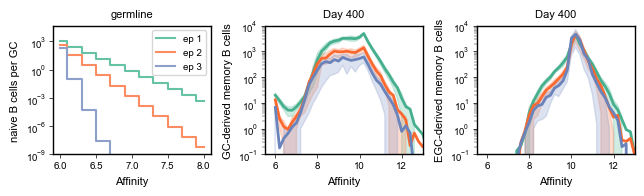

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(16.475 / cm_in_inch, 5.1 / cm_in_inch))
colors = epitope_colors(3)
aff_distr = utils.read_pickle(DIR/'masking_sweep_C0_1.0/sweep_1/aff_distr.pkl')
for i in range(3):
    #plot step-like bar plot for germline affinity distribution
    ax[0].step(np.array(sim.fitness_array), sim.naive_bcells_arr[i, :], where="mid", color=colors[i], label=f"ep {i+1}")
    #memory GC B cell affinity distribution at day 400
    gc_data = aff_distr["memory_gc"][-1, :, i, :]
    ax[1].plot(aff_distr['affinity_bins'], gc_data.mean(axis=0), lw=2, label=f'ep {i+1}', color=darken_color(colors[i], 0.1))
    ax[1].fill_between(aff_distr['affinity_bins'], np.percentile(gc_data, 25, axis=0), np.percentile(gc_data, 75, axis=0),
                            color=colors[i], alpha=0.3, label=None)
    #memory EGC B cell affinity distribution at day 400
    egc_data = aff_distr["memory_egc"][-1, :, i, :]
    ax[2].plot(aff_distr['affinity_bins'], egc_data.mean(axis=0), lw=2, label=f'ep {i+1}', color=darken_color(colors[i], 0.1))
    #ax[2].plot(aff_distr['affinity_bins'], np.percentile(egc_data, 25, axis=0), lw=2, label=f'ep {i+1}', color=colors[i])
    #ax[2].plot(aff_distr['affinity_bins'], np.percentile(egc_data, 75, axis=0), lw=2, label=f'ep {i+1}', color=colors[i])
    ax[2].fill_between(aff_distr['affinity_bins'], np.percentile(egc_data, 25, axis=0), np.percentile(egc_data, 75, axis=0),
                            color=colors[i], alpha=0.3, label=None)

ax[0].set_xlabel("Affinity")
ax[0].set_ylabel("naive B cells per GC")
ax[0].set_yscale('log')
ax[0].set_title('germline')
ax[0].legend()
ax[0].set_ylim(bottom=1e-9)
ax[1].set_xlabel("Affinity")
ax[1].set_ylabel("GC-derived memory B cells")
ax[1].set_xlim(right=13)
ax[1].set_ylim(bottom=1e-1, top=1e4)
ax[1].set_yscale('log')
ax[1].set_title('Day 400')
ax[2].set_xlabel("Affinity")
ax[2].set_ylabel("EGC-derived memory B cells")
ax[2].set_xlim(right=13)
ax[2].set_ylim(bottom=1e-1, top=1e4)
ax[2].set_yscale('log')
ax[2].set_title('Day 400')
fig.tight_layout()
plt.savefig(PLOT_DIR/'S1_affinity_distributions.pdf')

In [23]:
results = utils.read_pickle(DIR/'masking_sweep_C0_1.0/sweep_1/conc_cells.pkl')
nreplicates = results["plasma_gc"].shape[1]
n_ep = results["plasma_gc"].shape[-1]
time = results["time"]
colors = sns.color_palette("Set2", n_ep)
mean_fn = functools.partial(np.mean, axis=1)

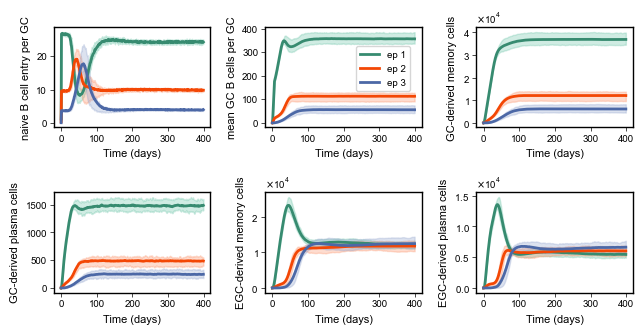

In [43]:
import matplotlib.ticker as mticker

fig, ax = plt.subplots(2, 3, figsize=(16.475 / cm_in_inch, 8.6 / cm_in_inch))
ax = ax.flatten()

# Configure a ScalarFormatter for scientific notation
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))

fields = ['naive_entry', 'gc', 'memory_gc', 'plasma_gc', 'memory_egc', 'plasma_egc']
labels = ['naive B cell entry per GC', 'mean GC B cells per GC', 'GC-derived memory cells', 'GC-derived plasma cells',
          'EGC-derived memory cells', 'EGC-derived plasma cells']

for k in range(6):
    for i in range(n_ep):
        """ NAIVE B CELL ENTRY """
        ax[k].plot(time, mean_fn(results[fields[k]][:, :, i]), color=darken_color(colors[i], 0.2), lw=2, label=f'ep {i+1}')
        ax[k].fill_between(time, np.percentile(results[fields[k]][:, :, i], 25, axis=1), np.percentile(results[fields[k]][:, :, i], 75, axis=1),
                             color=colors[i], alpha=0.3, label=None)
    ax[k].set_xlabel('Time (days)')
    ax[k].set_ylabel(labels[k])
        

ax[1].legend(loc='lower left', bbox_to_anchor=(220, 115), bbox_transform=ax[1].transData)
ax[2].yaxis.set_major_formatter(formatter)
ax[4].yaxis.set_major_formatter(formatter)
ax[5].yaxis.set_major_formatter(formatter)
fig.tight_layout()
fig.subplots_adjust(wspace=0.35, hspace=0.65)
plt.savefig(PLOT_DIR/'S2_bcell_dynamics.pdf')

In [22]:
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm

def get_titers_from_sweep_csv(df, param1, param2, **kwargs):
    """ Plot a heatmap of the minimum [Ab]/Kd amongst the 3 epitopes as a function of 
    params1 and 2 in a combinatorial sweep fixing all other parameters (specified in kwargs). """
    
    filtered_df = df
    for key, value in kwargs.items():
        filtered_df = filtered_df[filtered_df[key] == value]
    
    values1 = np.unique(filtered_df[param1])
    values2 = np.unique(filtered_df[param2])
    param1_grid, param2_grid = np.meshgrid(values1, values2, indexing='xy')
    titer_matrix = np.zeros((len(values2), len(values1)))
    ep1_titer_matrix = np.zeros((len(values2), len(values1)))
    ep2_titer_matrix = np.zeros((len(values2), len(values1)))
    ep3_titer_matrix = np.zeros((len(values2), len(values1)))
    gc_size_matrix = np.zeros((len(values2), len(values1)))
    for i in range(len(values1)):
        for j in range(len(values2)):
            row = filtered_df.loc[(filtered_df[param1] == param1_grid[j, i]) & (filtered_df[param2] == param2_grid[j, i])]
            try:
                path = row['path'].values[0]
            except:
                print(row)
                titer_matrix[j, i] = np.nan
                gc_size_matrix[j, i] = np.nan
                continue
            n_ep = row['n_conserved_epitopes'] + row['n_ag'] * row['n_variable_epitopes']
            titers = [row[f'ep{i+1}_titer_d400'].values[0] for i in range(n_ep.values[0])]
            ep1_titer_matrix[j, i] = titers[0]
            ep2_titer_matrix[j, i] = titers[1]
            ep3_titer_matrix[j, i] = titers[2]
            titer_matrix[j, i] = min(titers)
            gc_size_matrix[j, i] = row['gc_size_d400'].values[0]
    return param1_grid, param2_grid, titer_matrix, ep1_titer_matrix, ep2_titer_matrix, ep3_titer_matrix, gc_size_matrix
    

/state/partition1/slurm_tmp/28187621.0.0/ipykernel_632233/897551986.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plasma = cm.get_cmap('plasma')
/state/partition1/slurm_tmp/28187621.0.0/ipykernel_632233/897551986.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap('jet')


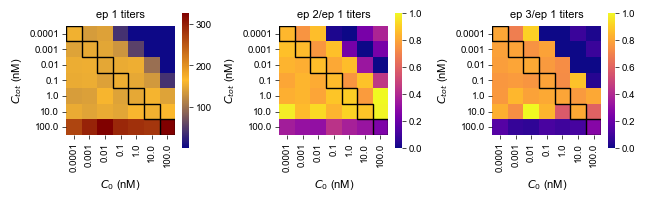

In [32]:
df = pd.read_csv(DIR/'3_epitope_sweep_C_C0/sweep_map.csv')
C0_grid, fdc_grid, titers, ep1_titers, ep2_titers, ep3_titers, gc_sizes = get_titers_from_sweep_csv(df, "C0", "fdc_capacity")

# Create a figure with 3 subplots for the 3 epitopes
fig, axes = plt.subplots(1, 3, figsize=(16.475 / cm_in_inch, 5.1 / cm_in_inch))

# Define the log normalization for the heatmaps
lognorm = Normalize(vmin=0, vmax=300)

# Titles for each subplot
titles = [r'ep 1 titers', r'ep 2/ep 1 titers', r'ep 3/ep 1 titers']

# Plot heatmaps for each epitope
epitope_titers = [ep1_titers, ep2_titers/ep1_titers, ep3_titers/ep1_titers]
norm = Normalize(vmin=0, vmax=1.0)

# Get the plasma colormap
plasma = cm.get_cmap('plasma')
jet = cm.get_cmap('jet')
# Choose key colors:
# Sample a dark blue/purple from the lower end
dark_color = plasma(0.0)  
# Sample an orange/yellow from the middle
center_color = plasma(0.85)  
# Define red explicitly for the high end
high_color = jet(1.0)

# Create a custom colormap that interpolates between these colors
custom_cmap = LinearSegmentedColormap.from_list("custom_seq", 
                                                [dark_color, center_color, high_color])

for i, (ep_titers, ax) in enumerate(zip(epitope_titers, axes)):
    if i > 0: 
        sns.heatmap(ep_titers, cmap="plasma", robust=True, 
                    norm=norm,
                    cbar_kws={'norm': norm},
                    yticklabels=[f"{fdc}" for fdc in fdc_grid[:, 0]], 
                    xticklabels=[f"{C0}" for C0 in C0_grid[0, :]], 
                    mask=np.isnan(ep_titers), square=True, ax=ax)
    else:
        sns.heatmap(ep_titers, cmap=custom_cmap, robust=True, 
                    yticklabels=[f"{fdc}" for fdc in fdc_grid[:, 0]], 
                    xticklabels=[f"{C0}" for C0 in C0_grid[0, :]], 
                    mask=np.isnan(ep_titers), square=True, ax=ax)
    
    # Set axis labels and title
    ax.set_ylabel(r'$C_{tot}$ (nM)')
    ax.set_xlabel(r'$C_0$ (nM)')
    ax.set_title(titles[i])
    
    # Draw black outlines on the diagonal squares
    num_rows, num_cols = ep_titers.shape
    for j in range(min(num_rows, num_cols)):  # Ensure we stay within bounds
        if not np.isnan(ep_titers[j, j]):  # Only outline non-NaN entries
            rect = patches.Rectangle((j, j), 1, 1, fill=False, edgecolor='black', lw=1)
            ax.add_patch(rect)

# Adjust layout for better spacing
fig.tight_layout()
#plt.show()
plt.savefig(PLOT_DIR/'S3_C_C0_sweep.pdf')

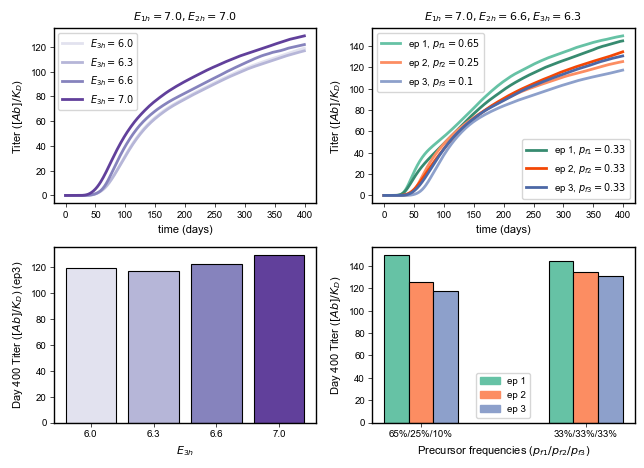

In [22]:
# Plot titers over time to epitope 3 as a function of E3h, keeping E1h and E2h fixed
import matplotlib.patches as mpatches

df = pd.read_csv(DIR/'germline_affinity_sweep/sweep_map.csv')    
df = df[df['E1h']==7.0]
df = df[df['E2h']==7.0]
num_sims = len(np.unique(df['E3h'].values))
colors = sns.color_palette("Purples", num_sims)
ep_colors = epitope_colors(3)

# first figure out which parameters were swept, based on number of unique values in each column
params = list(df.columns)
params.remove('path')
df_excl_path = df[params]
unique_counts = np.array(df_excl_path.nunique())
swept_params = np.array(params)[unique_counts > 1]
concentrations = ["ab_conc", "ab_ka", "ic_fdc_eff_conc"]
conc_titles = ['[Ab] (nM)', '$K_a$ (nM$^{-1}$)', 'Unmasked [Ag] on FDC']
n_ep = int(df['n_conserved_epitopes'].iloc[0] + df['n_variable_epitopes'].iloc[0] * df['n_ag'].iloc[0])
mean_fn = functools.partial(np.mean, axis=1)

### NEW: 2x2 layout to add two bar charts below
fig, ax = plt.subplots(2, 2, figsize=(16.475 / cm_in_inch, 12 / cm_in_inch))

# -------------------- Top-left: time courses of ep3 across E3h --------------------
i = 0
e3h_vals = []           ### NEW: capture for bottom-left bars
day400_ep3_means = []   ### NEW: capture for bottom-left bars
for E3h, mat in df.groupby('E3h'):
    path = mat['path'].values[0]
    path = path.replace("gc_dynamics", "hiv-bnab")
    mat = mat.sort_values('E3h')
    results = utils.read_pickle(Path(path)/'conc_cells.pkl')
    titer = results["titer"]  # shape: time x sims x epitopes
    time = results["time"]
    ax[0, 0].plot(time[0:400], mean_fn(titer[0:400, :, 2]), color=colors[i], lw=2, label=f"$E_{{3h}}={E3h}$")

    ### NEW: get mean titer at (closest to) day 400 for epitope 3
    t_idx = int(np.argmin(np.abs(time - 400)))
    e3h_vals.append(E3h)
    day400_ep3_means.append(mean_fn(titer[t_idx:t_idx+1, :, 2])[0])
    i += 1

ax[0, 0].set_ylabel('Titer ($[Ab]/K_D$)')
ax[0, 0].set_xlabel('time (days)')
ax[0, 0].set_title('$E_{1h}=7.0, E_{2h}=7.0$')
ax[0, 0].legend()

# -------------------- Top-right: time courses for ep1/ep2/ep3 under two pf sets --------------------
df = pd.read_csv(DIR/'germline_affinity_sweep/sweep_map.csv')
df = df[df['E1h']==7.0]
df = df[df['E2h']==6.6]
df = df[df['E3h']==6.3].iloc[0]
df2 = pd.read_csv(DIR/'germline_affinity_sweep_balanced_ntf/sweep_map.csv')
df2 = df2[df2['E1h']==7.0]
df2 = df2[df2['E2h']==6.6]
df2 = df2[df2['E3h']==6.3].iloc[0]

darker_ep_colors = [darken_color(color, 0.2) for color in ep_colors]
ntfs = [0.65, 0.25, 0.1]
balanced_ntfs = [0.33, 0.33, 0.33]
handles_ntfs = []
handles_balanced = []

# NEW: capture day-400 titers per epitope for clustered bar chart
unbalanced_day400 = []
balanced_day400 = []

for i in range(3):
    # unbalanced titers
    path = df['path'].replace("gc_dynamics", "hiv-bnab")
    results = utils.read_pickle(Path(path)/'conc_cells.pkl')
    line1, = ax[0, 1].plot(results["time"][0:400], mean_fn(results["titer"][0:400, :, i]), 
            color=ep_colors[i], lw=2, label=f"ep {i+1}, $p_{{f{i+1}}}={ntfs[i]}$")
    handles_ntfs.append(line1)
    # day-400 value
    t_idx = int(np.argmin(np.abs(results["time"] - 400)))
    unbalanced_day400.append(mean_fn(results["titer"][t_idx:t_idx+1, :, i])[0])

    # balanced titers
    path = df2['path'].replace("gc_dynamics", "hiv-bnab")
    results2 = utils.read_pickle(Path(path)/'conc_cells.pkl')
    line2, = ax[0, 1].plot(results2["time"][0:400], mean_fn(results2["titer"][0:400, :, i]), 
            color=darker_ep_colors[i], lw=2, label=f"ep {i+1}, $p_{{f{i+1}}}={balanced_ntfs[i]}$")
    handles_balanced.append(line2)
    # day-400 value
    t_idx2 = int(np.argmin(np.abs(results2["time"] - 400)))
    balanced_day400.append(mean_fn(results2["titer"][t_idx2:t_idx2+1, :, i])[0])

ax[0, 1].set_ylabel('Titer ($[Ab]/K_D$)')
ax[0, 1].set_xlabel('time (days)')
ax[0, 1].set_title('$E_{1h}=7.0, E_{2h}=6.6, E_{3h}=6.3$')

# Create the first legend for the ntfs group (upper left)
legend_ntfs = ax[0, 1].legend(handles=handles_ntfs, loc='upper left')
ax[0, 1].add_artist(legend_ntfs)  # Add the first legend as an artist

# Create the second legend for the balanced_ntfs group (lower right)
legend_balanced = ax[0, 1].legend(handles=handles_balanced, loc='lower right')

# -------------------- Bottom-left: bar chart of day-400 ep3 vs E3h --------------------
e3h_sorted_idx = np.argsort(e3h_vals)
e3h_vals_sorted = np.array(e3h_vals)[e3h_sorted_idx]
day400_ep3_sorted = np.array(day400_ep3_means)[e3h_sorted_idx]

ax[1, 0].bar(
    np.arange(len(e3h_vals_sorted)),
    day400_ep3_sorted,
    color=[colors[j] for j in e3h_sorted_idx],
    edgecolor='black', linewidth=0.8  # <-- black outline
)
ax[1, 0].set_xticks(np.arange(len(e3h_vals_sorted)))
ax[1, 0].set_xticklabels([f"{v:.1f}" for v in e3h_vals_sorted])
ax[1, 0].set_xlabel("$E_{3h}$")
ax[1, 0].set_ylabel("Day 400 Titer ($[Ab]/K_D$) (ep3)")

# -------------------- Bottom-right: clustered bars for pf scenarios --------------------
cluster_labels = ["65%/25%/10%", "33%/33%/33%"]
n_ep = 3
bar_width = 0.15
cluster_positions = np.array([0, 1]) + (n_ep + 1) * bar_width/2

# unbalanced (cluster 0) with black outlines
for i in range(n_ep):
    ax[1, 1].bar(
        cluster_positions[0] + i * bar_width,
        unbalanced_day400[i],
        width=bar_width,
        color=ep_colors[i],
        edgecolor='black', linewidth=0.8   # <-- black outline
    )

# balanced (cluster 1) with black outlines
for i in range(n_ep):
    ax[1, 1].bar(
        cluster_positions[1] + i * bar_width,
        balanced_day400[i],
        width=bar_width,
        color=ep_colors[i],
        edgecolor='black', linewidth=0.8   # <-- black outline
    )

cluster_centers = cluster_positions + (n_ep-1)*bar_width/2
ax[1, 1].set_xticks(cluster_centers)
ax[1, 1].set_xticklabels(cluster_labels)
ax[1, 1].set_ylabel("Day 400 Titer ($[Ab]/K_D$)")
ax[1, 1].set_xlabel("Precursor frequencies ($p_{f1}/p_{f2}/p_{f3}$)")

# Legend for ep1/ep2/ep3 (explicit handles so all three show)
ep_handles = [mpatches.Patch(color=ep_colors[i], label=f"ep {i+1}") for i in range(3)]
ax[1, 1].legend(handles=ep_handles)  # no title

fig.tight_layout()
plt.savefig(PLOT_DIR/'figS7_germline_affinities_ntf.pdf')

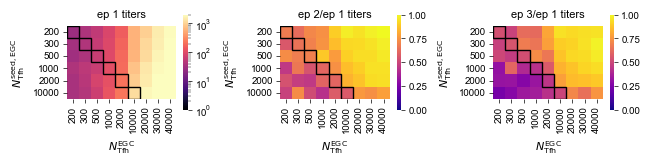

In [34]:
df = pd.read_csv(DIR/'seeding_egc_ntfh_egc_sweep/sweep_map.csv')
ntfh_egc_grid, seeding_egc_grid, titers, ep1_titers, ep2_titers, ep3_titers, gc_size_matrix = get_titers_from_sweep_csv(df, "n_tfh_egc", "seeding_tcells_egc")

# Create a figure with 3 subplots for the 3 epitopes
fig, axes = plt.subplots(1, 3, figsize=(16.475 / cm_in_inch, 4.0 / cm_in_inch))

# Define the log normalization for the heatmaps
lognorm = LogNorm(vmin=1, vmax=2000)

# Titles for each subplot
titles = [r'ep 1 titers', r'ep 2/ep 1 titers', r'ep 3/ep 1 titers']

# Plot heatmaps for each epitope
epitope_titers = [ep1_titers, ep2_titers/ep1_titers, ep3_titers/ep1_titers]
norm = Normalize(vmin=0, vmax=1.0)

for i, (ep_titers, ax) in enumerate(zip(epitope_titers, axes)):
    if i > 0: 
        sns.heatmap(ep_titers, cmap="plasma", robust=True, 
                    norm=norm,
                    cbar_kws={'norm': norm},
                    yticklabels=[f"{ntfh}" for ntfh in seeding_egc_grid[:, 0]], 
                    xticklabels=[f"{ntfh}" for ntfh in ntfh_egc_grid[0, :]], 
                    mask=np.isnan(ep_titers), square=True, ax=ax)
    else:
        sns.heatmap(ep_titers, cmap="magma", robust=False, 
                    norm=lognorm,
                    cbar_kws={'norm': lognorm},
                    yticklabels=[f"{ntfh}" for ntfh in seeding_egc_grid[:, 0]], 
                    xticklabels=[f"{ntfh}" for ntfh in ntfh_egc_grid[0, :]],  
                    mask=np.isnan(ep_titers), square=True, ax=ax)
    
    # Set axis labels and title
    ax.set_ylabel(r'$N_{\rm Tfh}^{\rm seed, EGC}$')
    ax.set_xlabel(r'$N_{\rm Tfh}^{\rm EGC}$')
    ax.set_title(titles[i])
    
    # Draw black outlines on the diagonal squares
    num_rows, num_cols = ep_titers.shape
    for j in range(min(num_rows, num_cols)):  # Ensure we stay within bounds
        if not np.isnan(ep_titers[j, j]):  # Only outline non-NaN entries
            rect = patches.Rectangle((j, j), 1, 1, fill=False, edgecolor='black', lw=1)
            ax.add_patch(rect)

# Adjust layout for better spacing
fig.tight_layout()
#plt.show()
plt.savefig(PLOT_DIR/'S4_seeding_egc_ntfh_egc_sweep.pdf')

5       200
0       300
28      500
38     1000
15     2000
26    10000
8     20000
47    30000
48    40000
Name: n_tfh_egc, dtype: int64


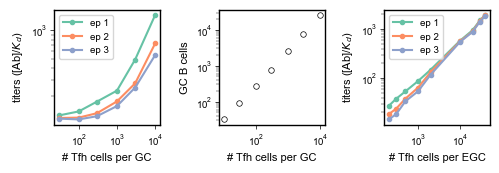

In [25]:
df = pd.read_csv(DIR/'ntfh_gc_sweep/sweep_map.csv')
tfh_vals = np.unique(df['n_tfh_gc'])
fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(12.8 / cm_in_inch, 4.5 / cm_in_inch))
df.sort_values('n_tfh_gc', inplace=True)
n_ep = int(df['n_conserved_epitopes'].iloc[0] + df['n_variable_epitopes'].iloc[0] * df['n_ag'].iloc[0])
colors = sns.color_palette("Set2", n_ep)
for i in range(n_ep):
    ax.plot(df['n_tfh_gc'].values[1:], df[f'ep{i+1}_titer_d400'].values[1:], '-o', color=colors[i], markersize=3, label=f'ep {i+1}')
ax.set_xlabel('# Tfh cells per GC')
ax.set_ylabel('titers ([Ab]/$K_d$)')
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()

df = pd.read_csv(DIR/'ntfh_gc_sweep/sweep_map.csv')
ax2.plot(df['n_tfh_gc'], df['gc_size_d400'], 'o', markersize=4, markeredgecolor='k', markeredgewidth=0.5, color='white')
ax2.set_xlabel('# Tfh cells per GC')
ax2.set_ylabel('GC B cells')
ax2.set_yscale('log')
ax2.set_xscale('log')

df = pd.read_csv(DIR/'seeding_egc_ntfh_egc_sweep/sweep_map.csv')
df = df[df["seeding_tcells_egc"]==200]
df = df.sort_values('n_tfh_egc')
print(df['n_tfh_egc'])
for i in range(n_ep):
    ax3.plot(df['n_tfh_egc'], df[f'ep{i+1}_titer_d400'], '-o', color=colors[i], markersize=3, label=f'ep {i+1}')
ax3.set_xlabel('# Tfh cells per EGC')
ax3.set_ylabel('titers ([Ab]/$K_d$)')
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.legend(loc="upper left")
fig.tight_layout()
plt.savefig(PLOT_DIR/'S4_end_titers_n_tfh.pdf')

In [26]:
#plot effect of increasing EGC plasma differentiation probability 
def plot_epitope_titers_bar_graph(df):
    df.sort_values('egc_output_pc_fraction', inplace=True)
    sim_labels = [f'{C}' for C in df['egc_output_pc_fraction']]
    n_epitopes = len([col for col in df.columns if 'ep' in col and 'titer_d400' in col])
    colors = epitope_colors(n_epitopes)

    fig, ax = plt.subplots(figsize=(16.475 / cm_in_inch, 4.0 / cm_in_inch))
    
    bar_width = 0.15
    indices = np.arange(len(df)) * (n_epitopes * bar_width + 0.1)
    
    for i, ep in enumerate(range(1, n_epitopes + 1)):
        bar_positions = indices + i * bar_width
        ax.bar(bar_positions, df[f'ep{ep}_titer_d400'], width=bar_width, label=f'ep {ep}', color=colors[i], edgecolor='black')
    
    ax.set_ylabel('Titers ($[Ab]/K_d$)')
    ax.set_xlabel('EGC plasma cell differentiation probability')
    ax.legend()
    #ax.set_yscale('log')  
    #ax.axhline(y=10, color='black', linestyle='--') 
    ax.set_xticks(indices + (n_epitopes - 1) * bar_width / 2)
    ax.set_xticklabels(sim_labels)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    fig.tight_layout()
    plt.savefig(PLOT_DIR/f'titers_vs_egc_output_pc_fraction.pdf')


In [27]:
df = pd.read_csv(DIR/'egc_plasma_sweep_ntfh_gc_1000/sweep_map.csv')
df = df[df['egc_recycle_daughter']==False]
df2 = pd.read_csv(DIR/'egc_noncyclic_plasma_sweep/sweep_map.csv')
df = pd.concat([df, df2], axis=0)
df

,simulation_time,n_conserved_epitopes,n_variable_epitopes,n_ag,fdc_capacity,C0,bcell_birth_rate,bcell_death_rate,seeding_tcells_gc,n_tfh_gc,...,egc_output_pc_fraction,memory_to_gc_fraction,n_naive_precursors,write_simulation,seed,path,ep1_titer_d400,ep2_titer_d400,ep3_titer_d400,gc_size_d400
2,400,3,0,2,1.0,1.0,2.77,0.4,10,1000,...,0.8,0,2000,False,0,/home/gridsan/dkannan/git-remotes/hiv-bnab/see...,167.649326,62.102888,19.419486,2557.6925
3,400,3,0,2,1.0,1.0,2.77,0.4,10,1000,...,0.3,0,2000,False,0,/home/gridsan/dkannan/git-remotes/hiv-bnab/see...,211.433460,167.796343,154.016376,2563.4465
4,400,3,0,2,1.0,1.0,2.77,0.4,10,1000,...,0.6,0,2000,False,0,/home/gridsan/dkannan/git-remotes/hiv-bnab/see...,195.696729,64.490011,29.105549,2553.0325
7,400,3,0,2,1.0,1.0,2.77,0.4,10,1000,...,1.0,0,2000,False,0,/home/gridsan/dkannan/git-remotes/hiv-bnab/see...,159.870436,56.056584,18.562835,2558.8045
0,400,3,0,2,1.0,1.0,2.77,0.4,10,1000,...,0.4,0,2000,False,0,/home/gridsan/dkannan/git-remotes/hiv-bnab/see...,294.615711,202.638490,176.444795,2551.3645
1,400,3,0,2,1.0,1.0,2.77,0.4,10,1000,...,0.1,0,2000,False,0,/home/gridsan/dkannan/git-remotes/hiv-bnab/see...,116.572155,77.818265,81.659234,2566.6795
2,400,3,0,2,1.0,1.0,2.77,0.4,10,1000,...,0.5,0,2000,False,0,/home/gridsan/dkannan/git-remotes/hiv-bnab/see...,310.817929,130.110680,62.271189,2552.5140


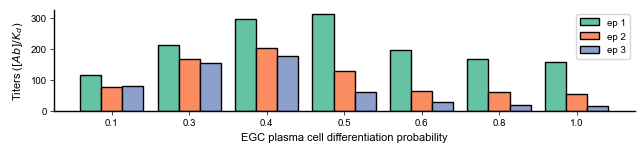

In [28]:
plot_epitope_titers_bar_graph(df)

In [31]:
def plot_4panel_epitope_titers_masking(df, n_epitopes=6):
    """Create a 4-panel figure showing memory_gc B cell counts and antibody titers in a permuted epitope order."""
    
    # Custom epitope order
    permuted_order = [1, 2, 3, 4, 5, 6]
    
    # Create figure with 4 subplots
    fig, axes = plt.subplots(2, 2, figsize=(16.475 / cm_in_inch, 10.0 / cm_in_inch))
    bar_width = 0.15
    colors = epitope_colors(n_epitopes, ep_per_ag=3)
    
    # Define the 4 panel configurations
    panels = [
        {'egc_output_pc_fraction': 0.3, 'title': 'MBC→PC p=0.3', 'position': (0, 0), 'type': 'memory'},
        {'egc_output_pc_fraction': 0.3, 'title': 'MBC→PC p=0.3', 'position': (0, 1), 'type': 'titers'},
        {'egc_output_pc_fraction': 0.6, 'title': 'MBC→PC p=0.6', 'position': (1, 0), 'type': 'memory'},
        {'egc_output_pc_fraction': 0.6, 'title': 'MBC→PC p=0.6', 'position': (1, 1), 'type': 'titers'}
    ]
    k = 0
    for panel in panels:
        row, col = panel['position']
        ax = axes[row, col]
        pc_fraction = panel['egc_output_pc_fraction']
        panel_type = panel['type']
        
        # Filter data for this PC fraction
        mask = (df['egc_output_pc_fraction'] == pc_fraction)
        subset = df[mask]
        
        if panel_type == 'memory':  # Memory B cell counts
            memory_data = []
            for masking in [0, 1]:
                mask_subset = subset[subset['masking'] == masking]
                path = mask_subset.iloc[0]['path']
                results = utils.read_pickle(Path(path)/'conc_cells.pkl')
                ep_MBCs = results['memory_gc'][-1].mean(axis=0)
                memory_data.append(ep_MBCs)

            memory_data = np.array(memory_data)
            indices = np.arange(len(memory_data)) * (n_epitopes * bar_width + 0.1)

            for i, ep in enumerate(permuted_order):
                bar_positions = indices + i * bar_width
                ax.bar(bar_positions, memory_data[:, ep - 1], width=bar_width,
                       label=f'ep {ep}', color=colors[ep - 1], edgecolor='black')

            ax.set_title(f'{n_epitopes} epitopes, MBC->PC p={pc_fraction}')
            ax.set_ylabel('GC-derived MBCs')
            ax.set_xticks(indices + (n_epitopes - 1) * bar_width / 2)
            ax.set_xticklabels(['No masking', 'masking'])

        else:  # Antibody titers
            indices = np.arange(len(subset)) * (n_epitopes * bar_width + 0.1)

            for i, ep in enumerate(permuted_order):
                bar_positions = indices + i * bar_width
                ax.bar(bar_positions, subset[f'ep{ep}_titer_d400'], width=bar_width,
                       label=f'ep {ep}', color=colors[ep - 1], edgecolor='black')

            ax.set_ylabel('Titers ([Ab]/$K_d$)')
            ax.set_title(f'{n_epitopes} epitopes, MBC->PC p={pc_fraction}')
            ax.set_xticks(indices + (n_epitopes - 1) * bar_width / 2)
            ax.set_xticklabels(['No masking', 'masking'])
        if k==0:
            ax.legend()
        k += 1
    
    plt.tight_layout()
    plt.savefig(PLOT_DIR/'6_epitopes_masking_ntfh_gc_1000_MBC_titers.pdf')

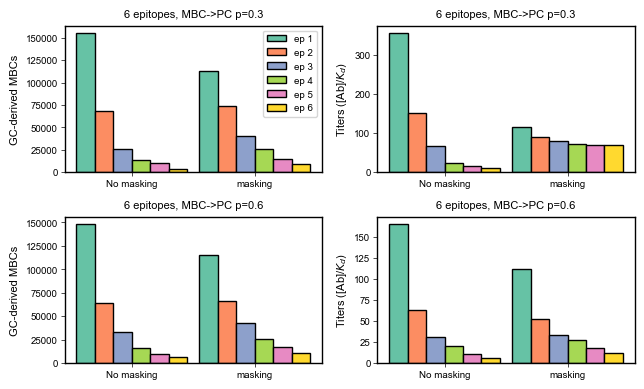

In [32]:
df = pd.read_csv(DIR/f'6_epitopes_masking_ntfh_gc_1000/sweep_map.csv')
df.sort_values('masking', inplace=True)
df.sort_values('egc_output_pc_fraction', inplace=True)
plot_4panel_epitope_titers_masking(df, n_epitopes=6)

In [16]:
#plot effect of increasing EGC plasma differentiation probability 
def plot_epitope_titers_stringency(df):
    df.sort_values('stringency', inplace=True)
    sim_labels = [f'{K}' for K in df['stringency']]
    n_epitopes = len([col for col in df.columns if 'ep' in col and 'titer_d400' in col])
    colors = epitope_colors(n_epitopes)

    fig, axes = plt.subplots(1, 2, figsize=(11.4 / cm_in_inch, 5.0 / cm_in_inch))
    ax1, ax2 = axes
    #plot GC-derived MBCs vs K
    memory_data = []
    for K in df['stringency'].values:
        subset = df[df['stringency']==K]
        path = subset.iloc[0]['path']
        results = utils.read_pickle(Path(path)/'conc_cells.pkl')
        ep_MBCs = results['memory_gc'][-1].mean(axis=0)
        memory_data.append(ep_MBCs)
    memory_data = np.array(memory_data) 
    for i in range(n_epitopes):
        ax1.plot(df['stringency'].values, memory_data[:, i], '-o', color=colors[i], markersize=3, label=f'ep {i+1}')
    ax1.set_ylabel('GC-derived MBCs')
    ax1.set_xlabel('Stringency of selection (K)')
    ax1.legend()
        
    #plot titers vs K
    for i in range(n_epitopes):
        ax2.plot(df['stringency'].values, df[f'ep{i+1}_titer_d400'].values, '-o', color=colors[i], markersize=3, label=f'ep {i+1}')
    
    ax2.set_ylabel('Titers ($[Ab]/K_d$)')
    ax2.set_xlabel('Stringency of selection (K)')
    ax2.legend()

    fig.tight_layout()
    plt.savefig(PLOT_DIR/f'titers_vs_stringency_K.pdf')

In [17]:
df = pd.read_csv(DIR/'K_sweep/sweep_map.csv')
df.sort_values('stringency', inplace=True)

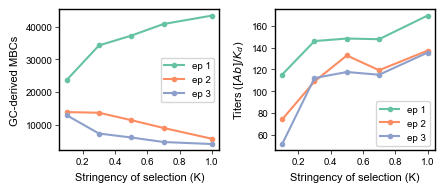

In [18]:
plot_epitope_titers_stringency(df)